In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy as sp
import matplotlib as mpl
import seaborn as sns

# Setting up Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

# Setting up Seaborn
sns.set_style("whitegrid")
#sns.set_context("poster")

%matplotlib inline

In [4]:
train = pd.read_csv('training_data.csv')
test = pd.read_csv('test_data.csv')

In [3]:
training = train.drop('status_group', axis=1)

In [4]:
training = training.drop('Unnamed: 0', axis=1)

test = test.drop('Unnamed: 0', axis=1)

In [5]:
##Plot function for Confusion Matrix

#plt.rcParams['figure.figsize'] = (6.0, 6.0)
from sklearn.metrics import confusion_matrix
labels=['functional','functional needs repair','non functional']
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.YlOrRd):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha='right', fontsize=12)
    plt.yticks(tick_marks, labels , fontsize=12)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

## Because we are having maximum amount of Categorical data let us transform the features, and convert them into list

In [6]:
def transform_feature(df, column_name):
    unique_values = set(df[column_name].tolist())
    transformer_dict = {}
    for index, value in enumerate(unique_values):
        transformer_dict[value] = index
    df[column_name] = df[column_name].apply(lambda y: transformer_dict[y])
    return df

In [7]:
integer_columns = ['days_since_recorded', 'population','gps_height'] 
columns_to_transform = [col for col in training.columns if col not in integer_columns]
for column in columns_to_transform: 
    training = transform_feature(training, column)
    test = transform_feature(test, column)

## Now That we have Cleaned our dataset and Transformed our features, let us train our Model.

In [8]:
## Converting the Training dataframe into a matrix and predictor as y 
X = training.as_matrix()
y = train["status_group"].tolist()

> Splitting the Data Set with features into Train set  and Test set to train our model.

In [9]:
import sklearn.model_selection 
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, 
                                                                             y, 
                                                                             test_size = 0.3, 
                                                                             random_state = 0)

> As a part of EDA let us traing the data using different algorithms and findout which give us the better result.

The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability/robustness over a single estimator.

## Random Forest Classifier

In [10]:
import sklearn.ensemble

rfc = sklearn.ensemble.RandomForestClassifier(n_estimators=1000, 
                                              min_samples_split=5,
                                              criterion='gini', 
                                              max_features='auto',
                                              oob_score=True,
                                              random_state=1,
                                              n_jobs=-1)

In [11]:
rfc.fit(X_train, y_train)

print('Random Forest Classifier Train Accuracy Score :', rfc.score(X_train, y_train))
print('Random Forest Classifier Test Score :', rfc.score(X_test, y_test))

Random Forest Classifier Train Accuracy Score : 0.9527417027417028
Random Forest Classifier Test Score : 0.8060044893378226


In [12]:
print(rfc.feature_importances_)

[0.04015564 0.10704023 0.03038296 0.08148372 0.02448368 0.03665053
 0.10439463 0.05522831 0.01385804 0.02733839 0.04705411 0.01665736
 0.04840082 0.05123817 0.03341502 0.01447554 0.15761118 0.02379459
 0.00924012 0.04415619 0.03294078]


Text(0,0.5,'Importance')

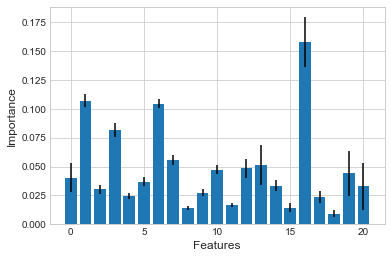

In [13]:
importance = rfc.feature_importances_
importance = pd.DataFrame(importance, index=training.columns, 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_ 
                            for tree in rfc.estimators_], axis=0)

x = range(importance.shape[0])
y = importance.iloc[:, 0]
yerr = importance.iloc[:, 1]
lables = list(training.columns.values)



ax = plt.bar(x, y, yerr=yerr ,align="center")
plt.xlabel('Features', fontsize = 12)
plt.ylabel('Importance', fontsize = 12)

#plt.show()

In [14]:
test.head()

,amount_tsh,days_since_recorded,funder,gps_height,installer,basin,subvillage,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,payment_type,water_quality,quantity_group,source_type,source_class,waterpoint_type,waterpoint_type_group
0,0,302,0,1996,0,1,3638,321,2,5,0,2,0,0,5,6,4,1,0,3,2
1,0,302,9,1569,7,2,2593,300,2,0,879,2,1,7,5,6,2,3,2,4,3
2,0,305,0,1567,0,1,4284,500,2,0,1651,1,0,0,5,6,2,1,0,3,2
3,0,315,0,267,0,6,6516,250,1,0,0,2,4,0,2,6,0,2,2,3,2
4,65,251,0,1260,0,6,8277,60,1,3,965,2,1,7,1,6,3,3,2,4,3


In [15]:
list(training.columns.values)

['amount_tsh',
 'days_since_recorded',
 'funder',
 'gps_height',
 'installer',
 'basin',
 'subvillage',
 'population',
 'public_meeting',
 'scheme_management',
 'scheme_name',
 'permit',
 'construction_year',
 'extraction_type',
 'payment_type',
 'water_quality',
 'quantity_group',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

In [16]:
from sklearn.metrics import classification_report

In [17]:
predicted = rfc.predict(X_test)

In [18]:
report = classification_report(y_test, predicted)
print(report)

                         precision    recall  f1-score   support

             functional       0.79      0.90      0.84      9612
functional needs repair       0.63      0.30      0.40      1333
         non functional       0.84      0.77      0.81      6875

            avg / total       0.80      0.81      0.80     17820



Confusion matrix
[[8673  165  774]
 [ 734  395  204]
 [1512   68 5295]]


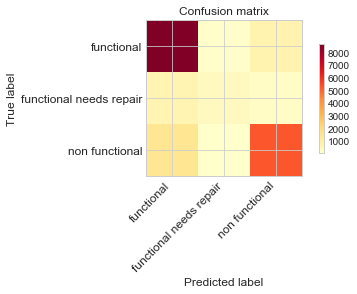

In [19]:
## Constructing the Confusion Matrix
cm = confusion_matrix(y_test, rfc.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

In [20]:
from sklearn.model_selection import cross_val_score  
all_accuracies = cross_val_score(estimator=rfc, X=X_train, y=y_train, cv=5)

In [21]:
print(all_accuracies)

[0.8 0.8 0.8 0.8 0.8]


In [22]:
print(all_accuracies.mean()) 

0.8010821435200363


In [23]:
print(all_accuracies.std())  

0.0029234468163992435


In [24]:
grid_param = {  
    'n_estimators': [100, 300, 500, 800, 1000],
    'min_samples_split': [5,10,15],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto',2,4,6]
}

In [25]:
from sklearn.model_selection import GridSearchCV

In [26]:
gd_sr = GridSearchCV(estimator=rfc,  
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [2]:
y_train.shape, X_train.shape

NameError: name 'y_train' is not defined

In [27]:
gd_sr.fit(X_train, y_train)

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\ProgramData\Anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\ProgramData\Anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x00000250F6279ED0, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\ProgramData\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\ProgramD...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x00000250F6279ED0, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\ProgramData\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\ProgramD...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         self.io_loop = ioloop.IOLoop.current()
    477         try:
--> 478             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    479         except KeyboardInterrupt:
    480             pass
    481 
    482 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 5
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 5), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 5)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=5)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'gd_sr.fit(X_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 6, 26, 17, 24, 10, 314755, tzinfo=tzutc()), 'msg_id': 'fd09f488338f46e792651c3ced92e657', 'msg_type': 'execute_request', 'session': '837547c3ade043c3a45ff7c31c6b9054', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'fd09f488338f46e792651c3ced92e657', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'837547c3ade043c3a45ff7c31c6b9054']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'gd_sr.fit(X_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 6, 26, 17, 24, 10, 314755, tzinfo=tzutc()), 'msg_id': 'fd09f488338f46e792651c3ced92e657', 'msg_type': 'execute_request', 'session': '837547c3ade043c3a45ff7c31c6b9054', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'fd09f488338f46e792651c3ced92e657', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'837547c3ade043c3a45ff7c31c6b9054'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'gd_sr.fit(X_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 6, 26, 17, 24, 10, 314755, tzinfo=tzutc()), 'msg_id': 'fd09f488338f46e792651c3ced92e657', 'msg_type': 'execute_request', 'session': '837547c3ade043c3a45ff7c31c6b9054', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'fd09f488338f46e792651c3ced92e657', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='gd_sr.fit(X_train, y_train)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'gd_sr.fit(X_train, y_train)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('gd_sr.fit(X_train, y_train)',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('gd_sr.fit(X_train, y_train)',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='gd_sr.fit(X_train, y_train)', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-27-0605bf83275a>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 2508041f710, executio..._before_exec=None error_in_exec=None result=None>)
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])
   2855                 code = compiler(mod, cell_name, "single")
-> 2856                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x00000250801A2540, file "<ipython-input-27-0605bf83275a>", line 1>
        result = <ExecutionResult object at 2508041f710, executio..._before_exec=None error_in_exec=None result=None>
   2857                     return True
   2858 
   2859             # Flush softspace
   2860             if softspace(sys.stdout, 0):

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x00000250801A2540, file "<ipython-input-27-0605bf83275a>", line 1>, result=<ExecutionResult object at 2508041f710, executio..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x00000250801A2540, file "<ipython-input-27-0605bf83275a>", line 1>
        self.user_global_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "import pandas as pd\nimport numpy as np\nimport ma..._ipython().run_line_magic('matplotlib', 'inline')", "train = pd.read_csv('training_data.csv')\ntest = pd.read_csv('test_data.csv')", "training = train.drop('status_group', axis=1)", "training = training.drop('Unnamed: 0', axis=1)\n\ntest = test.drop('Unnamed: 0', axis=1)", "##Plot function for Confusion Matrix\n\n#plt.rcPar...2)\n    plt.xlabel('Predicted label', fontsize=12)", 'def transform_feature(df, column_name):\n    uniq...pply(lambda y: transformer_dict[y])\n    return df', "integer_columns = ['days_since_recorded', 'popul...olumn)\n    test = transform_feature(test, column)", '## Converting the Training dataframe into a matr...ng.as_matrix()\ny = train["status_group"].tolist()', 'import sklearn.model_selection \nX_train, X_test,...                                random_state = 0)', 'import sklearn.ensemble\n\nrfc = sklearn.ensemble....                                       n_jobs=-1)', "rfc.fit(X_train, y_train)\n\nprint('Random Forest ...ssifier Test Score :', rfc.score(X_test, y_test))", 'print(rfc.feature_importances_)', "importance = rfc.feature_importances_\nimportance....ylabel('Importance', fontsize = 12)\n\n#plt.show()", 'test.head()', 'list(training.columns.values)', 'from sklearn.metrics import classification_report', 'predicted = rfc.predict(X_test)', 'report = classification_report(y_test, predicted)\nprint(report)', '## Constructing the Confusion Matrix\ncm = confus...\nprint(cm)\nplt.figure()\nplot_confusion_matrix(cm)', ...], 'Out': {13: Text(17.2469,0.5,'Importance'), 14:    amount_tsh  days_since_recorded  funder  gps_...        2                4                      3, 15: ['amount_tsh', 'days_since_recorded', 'funder', 'gps_height', 'installer', 'basin', 'subvillage', 'population', 'public_meeting', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'payment_type', 'water_quality', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type', ...]}, 'X': array([[  77,  995,    0, ...,    2,    4,    3]... 986,    6, ...,    2,    1,    0]], dtype=int64), 'X_test': array([[  0, 966,   0, ...,   2,   4,   3],
    ...  0, 958,   0, ...,   0,   4,   3]], dtype=int64), 'X_train': array([[   0,  286,    0, ...,    2,    0,    3]...1003,    0, ...,    2,    3,    2]], dtype=int64), '_': ['amount_tsh', 'days_since_recorded', 'funder', 'gps_height', 'installer', 'basin', 'subvillage', 'population', 'public_meeting', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'payment_type', 'water_quality', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type', ...], '_13': Text(17.2469,0.5,'Importance'), '_14':    amount_tsh  days_since_recorded  funder  gps_...        2                4                      3, '_15': ['amount_tsh', 'days_since_recorded', 'funder', 'gps_height', 'installer', 'basin', 'subvillage', 'population', 'public_meeting', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'payment_type', 'water_quality', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type', ...], ...}
        self.user_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "import pandas as pd\nimport numpy as np\nimport ma..._ipython().run_line_magic('matplotlib', 'inline')", "train = pd.read_csv('training_data.csv')\ntest = pd.read_csv('test_data.csv')", "training = train.drop('status_group', axis=1)", "training = training.drop('Unnamed: 0', axis=1)\n\ntest = test.drop('Unnamed: 0', axis=1)", "##Plot function for Confusion Matrix\n\n#plt.rcPar...2)\n    plt.xlabel('Predicted label', fontsize=12)", 'def transform_feature(df, column_name):\n    uniq...pply(lambda y: transformer_dict[y])\n    return df', "integer_columns = ['days_since_recorded', 'popul...olumn)\n    test = transform_feature(test, column)", '## Converting the Training dataframe into a matr...ng.as_matrix()\ny = train["status_group"].tolist()', 'import sklearn.model_selection \nX_train, X_test,...                                random_state = 0)', 'import sklearn.ensemble\n\nrfc = sklearn.ensemble....                                       n_jobs=-1)', "rfc.fit(X_train, y_train)\n\nprint('Random Forest ...ssifier Test Score :', rfc.score(X_test, y_test))", 'print(rfc.feature_importances_)', "importance = rfc.feature_importances_\nimportance....ylabel('Importance', fontsize = 12)\n\n#plt.show()", 'test.head()', 'list(training.columns.values)', 'from sklearn.metrics import classification_report', 'predicted = rfc.predict(X_test)', 'report = classification_report(y_test, predicted)\nprint(report)', '## Constructing the Confusion Matrix\ncm = confus...\nprint(cm)\nplt.figure()\nplot_confusion_matrix(cm)', ...], 'Out': {13: Text(17.2469,0.5,'Importance'), 14:    amount_tsh  days_since_recorded  funder  gps_...        2                4                      3, 15: ['amount_tsh', 'days_since_recorded', 'funder', 'gps_height', 'installer', 'basin', 'subvillage', 'population', 'public_meeting', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'payment_type', 'water_quality', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type', ...]}, 'X': array([[  77,  995,    0, ...,    2,    4,    3]... 986,    6, ...,    2,    1,    0]], dtype=int64), 'X_test': array([[  0, 966,   0, ...,   2,   4,   3],
    ...  0, 958,   0, ...,   0,   4,   3]], dtype=int64), 'X_train': array([[   0,  286,    0, ...,    2,    0,    3]...1003,    0, ...,    2,    3,    2]], dtype=int64), '_': ['amount_tsh', 'days_since_recorded', 'funder', 'gps_height', 'installer', 'basin', 'subvillage', 'population', 'public_meeting', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'payment_type', 'water_quality', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type', ...], '_13': Text(17.2469,0.5,'Importance'), '_14':    amount_tsh  days_since_recorded  funder  gps_...        2                4                      3, '_15': ['amount_tsh', 'days_since_recorded', 'funder', 'gps_height', 'installer', 'basin', 'subvillage', 'population', 'public_meeting', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'payment_type', 'water_quality', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type', ...], ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
D:\My Documents\Academic\UOM\L4S1\Data Mining\Mini Project\identifying_faulty_pumps\<ipython-input-27-0605bf83275a> in <module>()
----> 1 gd_sr.fit(X_train, y_train)

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py in fit(self=GridSearchCV(cv=5, error_score='raise',
       e...ore='warn',
       scoring='accuracy', verbose=0), X=array([[   0,  286,    0, ...,    2,    0,    3]...1003,    0, ...,    2,    3,    2]], dtype=int64), y=['non functional', 'functional', 'functional', 'functional', 'functional', 'functional needs repair', 'functional', 'functional', 'non functional', 'non functional', 'non functional', 'non functional', 'functional', 'functional', 'functional', 'functional', 'non functional', 'functional', 'non functional', 'non functional', ...], groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=5, random_state=None, shuffle=False)>
        X = array([[   0,  286,    0, ...,    2,    0,    3]...1003,    0, ...,    2,    3,    2]], dtype=int64)
        y = ['non functional', 'functional', 'functional', 'functional', 'functional', 'functional needs repair', 'functional', 'functional', 'non functional', 'non functional', 'non functional', 'non functional', 'functional', 'functional', 'functional', 'functional', 'non functional', 'functional', 'non functional', 'non functional', ...]
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Thu Jun 27 00:12:56 2019
PID: 10604                Python 3.6.4: C:\ProgramData\Anaconda3\python.exe
...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (RandomForestClassifier(bootstrap=True, class_wei...rue, random_state=1, verbose=0, warm_start=False), memmap([[   0,  286,    0, ...,    2,    0,    3...1003,    0, ...,    2,    3,    2]], dtype=int64), ['non functional', 'functional', 'functional', 'functional', 'functional', 'functional needs repair', 'functional', 'functional', 'non functional', 'non functional', 'non functional', 'non functional', 'functional', 'functional', 'functional', 'functional', 'non functional', 'functional', 'non functional', 'non functional', ...], {'score': make_scorer(accuracy_score)}, array([    0,     1,     2, ..., 41577, 41578, 41579]), array([16543, 16546, 16547, ..., 25243, 25244, 25287]), 0, {'criterion': 'entropy', 'max_features': 'auto', 'min_samples_split': 15, 'n_estimators': 800}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (RandomForestClassifier(bootstrap=True, class_wei...rue, random_state=1, verbose=0, warm_start=False), memmap([[   0,  286,    0, ...,    2,    0,    3...1003,    0, ...,    2,    3,    2]], dtype=int64), ['non functional', 'functional', 'functional', 'functional', 'functional', 'functional needs repair', 'functional', 'functional', 'non functional', 'non functional', 'non functional', 'non functional', 'functional', 'functional', 'functional', 'functional', 'non functional', 'functional', 'non functional', 'non functional', ...], {'score': make_scorer(accuracy_score)}, array([    0,     1,     2, ..., 41577, 41578, 41579]), array([16543, 16546, 16547, ..., 25243, 25244, 25287]), 0, {'criterion': 'entropy', 'max_features': 'auto', 'min_samples_split': 15, 'n_estimators': 800})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=RandomForestClassifier(bootstrap=True, class_wei...rue, random_state=1, verbose=0, warm_start=False), X=memmap([[   0,  286,    0, ...,    2,    0,    3...1003,    0, ...,    2,    3,    2]], dtype=int64), y=['non functional', 'functional', 'functional', 'functional', 'functional', 'functional needs repair', 'functional', 'functional', 'non functional', 'non functional', 'non functional', 'non functional', 'functional', 'functional', 'functional', 'functional', 'non functional', 'functional', 'non functional', 'non functional', ...], scorer={'score': make_scorer(accuracy_score)}, train=array([    0,     1,     2, ..., 41577, 41578, 41579]), test=array([16543, 16546, 16547, ..., 25243, 25244, 25287]), verbose=0, parameters={'criterion': 'entropy', 'max_features': 'auto', 'min_samples_split': 15, 'n_estimators': 800}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseForest.fit of RandomForestClas...ue, random_state=1, verbose=0, warm_start=False)>
        X_train = memmap([[   0,  286,    0, ...,    2,    0,    3...1003,    0, ...,    2,    3,    2]], dtype=int64)
        y_train = ['non functional', 'functional', 'functional', 'functional', 'functional', 'functional needs repair', 'functional', 'functional', 'non functional', 'non functional', 'non functional', 'non functional', 'functional', 'functional', 'functional', 'functional', 'non functional', 'functional', 'non functional', 'non functional', ...]
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py in fit(self=RandomForestClassifier(bootstrap=True, class_wei...rue, random_state=1, verbose=0, warm_start=False), X=array([[0.000e+00, 2.860e+02, 0.000e+00, ..., 2....0, 3.000e+00,
        2.000e+00]], dtype=float32), y=array([[2.],
       [0.],
       [0.],
       ...,
       [0.],
       [2.],
       [2.]]), sample_weight=None)
    329 
    330             # Collect newly grown trees
    331             self.estimators_.extend(trees)
    332 
    333         if self.oob_score:
--> 334             self._set_oob_score(X, y)
        self._set_oob_score = <bound method ForestClassifier._set_oob_score of...ue, random_state=1, verbose=0, warm_start=False)>
        X = array([[0.000e+00, 2.860e+02, 0.000e+00, ..., 2....0, 3.000e+00,
        2.000e+00]], dtype=float32)
        y = array([[2.],
       [0.],
       [0.],
       ...,
       [0.],
       [2.],
       [2.]])
    335 
    336         # Decapsulate classes_ attributes
    337         if hasattr(self, "classes_") and self.n_outputs_ == 1:
    338             self.n_classes_ = self.n_classes_[0]

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py in _set_oob_score(self=RandomForestClassifier(bootstrap=True, class_wei...rue, random_state=1, verbose=0, warm_start=False), X=array([[0.000e+00, 2.860e+02, 0.000e+00, ..., 2....0, 3.000e+00,
        2.000e+00]], dtype=float32), y=array([[2.],
       [0.],
       [0.],
       ...,
       [0.],
       [2.],
       [2.]]))
    444 
    445             if self.n_outputs_ == 1:
    446                 p_estimator = [p_estimator]
    447 
    448             for k in range(self.n_outputs_):
--> 449                 predictions[k][unsampled_indices, :] += p_estimator[k]
        predictions = [array([[  8.2261757 ,   0.53043478, 220.24338952...     [  5.11993781,   0.56944444, 209.31061774]])]
        k = 0
        unsampled_indices = array([    3,     7,     9, ..., 33251, 33252, 33255])
        p_estimator = [array([[0.84210526, 0.        , 0.        , 0.  ...0.06666667, 0.53333333, 0.        , 0.33333333]])]
    450 
    451         for k in range(self.n_outputs_):
    452             if (predictions[k].sum(axis=1) == 0).any():
    453                 warn("Some inputs do not have OOB scores. "

ValueError: operands could not be broadcast together with shapes (12294,3) (12294,5) (12294,3) 
___________________________________________________________________________

In [29]:
best_parameters = gd_sr.best_params_  
print(best_parameters)  

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [30]:
best_result = gd_sr.best_score_  
print(best_result)

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

## Predictions

In [ ]:
predict = rfc.predict(test)

In [ ]:
submission = pd.read_csv('SubmissionFormat.csv')

In [ ]:
Final_merge = pd.concat([test, submission], axis=1)

In [ ]:
Final_merge.head()

In [ ]:
Final_merge['status_group'] = predict

In [ ]:
Final_merge[['id','status_group']].to_csv('Prediction.csv', index=False)

In [ ]:
sub = pd.read_csv('Prediction.csv')

In [ ]:
sub.head()

In [ ]:
sub.status_group.value_counts()